# Identification of organic compounds from their refractive index using deep learning

---
This notebook is for a model developed using Visible region data which is obtained after data augmentation (Synthesizing refractive index data) using the sellmeier equation



In [1]:
# Install keras
# !pip install keras==2.1.6

In [2]:
#load the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

#New imports
# %tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout
# tf.keras.utils.to_categorical
%matplotlib inline

In [3]:
# Mounting google drive, to be able to write & read files on it
# This code block can only run on colab.research.google.com (Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing our uv_vis augmented data, currently using github hosted file.
This data is a result of data augmentation (Synthesizing refractive index data) using the sellmeier equation.

Data was increased from 1807 to 252770 rows


In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/innokirigiti/mypublicfolder/main/uv_visAugmentedData5000books.csv")
df.head()

,book,wl,n,k
0,22,0.4465,1.368170,0.000000e+00
1,22,0.3916,1.373850,2.109850e-07
2,6,0.6850,1.411420,0.000000e+00
3,36,0.4850,1.362881,0.000000e+00
4,18,0.5011,1.345787,0.000000e+00


# Data visualization and pre-processing

In [5]:
# Shape of the dataframe
df.shape

(252770, 4)

## One hot encoding targets (Classes of organic compounds) with integers

## Grouping data by wavelengths in 'UV' & 'Visible' in regions

In [6]:
# Shuffling data to make it random
df = df.sample(frac=1).reset_index(drop= True)
df.head()

,book,wl,n,k
0,27,0.379293,1.373388,0.0
1,23,0.265903,1.000780,0.0
2,32,0.284231,1.410107,0.0
3,8,0.338815,1.597691,0.0
4,53,0.061996,1.483313,0.0


In [7]:
# Describing the uv_vis data
df.describe()

,book,wl,n,k
count,252770.000000,252770.000000,252770.000000,252770.000000
mean,29.098956,0.379741,1.712891,0.000095
std,16.922419,0.215232,1.613322,0.006978
min,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.194704,1.399663,0.000000
50%,28.000000,0.382628,1.479020,0.000000
75%,43.000000,0.566004,1.596736,0.000000
max,59.000000,0.750000,44.076235,0.809000


In [8]:
# Classifying the wavelengths to different categories,based on the range of Wavelengths
df['wl_range'] = pd.cut(df['wl'], [0,0.4,np.inf], labels= ['UV', 'Visible'])
df.sample(3)

,book,wl,n,k,wl_range
168255,57,0.375466,1.589034,0.0,UV
210568,27,0.291356,1.390377,0.0,UV
160081,46,0.680596,1.386776,0.0,Visible


Let’s see how many of each class is in our data set

In [9]:
df['wl_range'].value_counts()

UV         132314
Visible    120455
Name: wl_range, dtype: int64

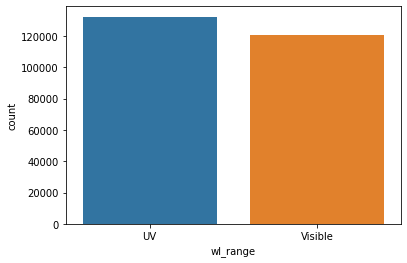

In [10]:
# Visualising
sns.countplot(x ='wl_range', data = df)

In [11]:
# Lets select only rows within Visible region
df = df.loc[df['wl_range'].isin(['Visible'])]
df.head()

,book,wl,n,k,wl_range
5,32,0.411522,1.388256,0.0,Visible
6,46,0.616465,1.388163,0.0,Visible
11,19,0.412176,1.000678,0.0,Visible
12,23,0.579709,1.000753,0.0,Visible
14,45,0.484497,1.505496,0.0,Visible


In [12]:
# Describe new df with only Visible region data
df.describe()

,book,wl,n,k
count,120455.000000,120455.000000,120455.000000,120455.000000
mean,28.946810,0.574511,1.433146,0.000005
std,16.929752,0.100524,0.150358,0.000115
min,0.000000,0.400004,0.884343,0.000000
25%,14.000000,0.487329,1.376815,0.000000
50%,28.000000,0.574690,1.446639,0.000000
75%,43.000000,0.660702,1.529560,0.000000
max,59.000000,0.750000,1.773391,0.003804


In [13]:
df.shape

(120455, 5)

## Feature selection/extraction
Creating predictors(X) and Targets(y) for Training and testing the Deep Learning model.

In [14]:
# Predictors / Features (X)
x = df.drop(['book', 'wl_range'], axis=1)

# Target (y)
y = df['book']   # Taget Vector

print('Shapes of Predictors & Targets')

print('Predictors (X): ', np.shape(x))
print('Targets (y): ', np.shape(y))

Shapes of Predictors & Targets
Predictors (X):  (120455, 3)
Targets (y):  (120455,)


## Normalizing Data


In [15]:
x_norm = (x - x.mean()) / x.std()
x_norm.sample(10)

,wl,n,k
212118,-0.827608,0.499384,-0.043282
106697,1.656218,-0.167672,-0.043282
49440,-0.132450,0.082880,-0.043282
242332,-0.328443,1.318954,-0.043282
76442,0.100059,-0.181077,-0.043282
56580,-0.556191,-0.598661,-0.043282
126877,-1.664387,-0.128810,-0.043282
1526,0.564935,-0.236893,-0.043282
116886,0.735141,1.144791,-0.043282
124692,-1.497972,-2.875663,-0.043282


# Train - Test data splitting 
`80%` for training and `20%` for testing



In [16]:
# split the data for training and testing
from sklearn.metrics import accuracy_score,classification_report
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size = 0.2,random_state=42)

In [17]:
print ('X - Train shape: ', x_train.shape)
print ('y - Train shape: ', y_train.shape)

print ('X - Test shape: ', x_test.shape)
print ('y - Test shape: ', y_test.shape)

X - Train shape:  (96364, 3)
y - Train shape:  (96364,)
X - Test shape:  (24091, 3)
y - Test shape:  (24091,)


In [18]:
# Converting our target into categorical
# (one hot encode outputs)
# The output of each prediction will be the 60 probalilities of corresponding 
# classes
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_test.shape[1]
print(num_classes)

60


In [19]:
# Building DL Classifier
# define classification model
def classification_model():
    # create model
    model = keras.Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape=(3,)))
    model.add(layers.Dense(100, activation='relu'))

    model.add(layers.Dense(num_classes, activation='softmax'))
 
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# build the model
model = classification_model()
epochs = 300

In [20]:
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                200       
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 60)                6060      
                                                                 
Total params: 11,360
Trainable params: 11,360
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Train, validate & test
# We are removing 30% of data from training set as Validation set
# & Fitting the model (Training)
history = model.fit(x_train, y_train, validation_split = 0.3, epochs = epochs, verbose=2)

Epoch 1/300
2108/2108 - 5s - loss: 2.0356 - accuracy: 0.3051 - val_loss: 1.4355 - val_accuracy: 0.4681 - 5s/epoch - 2ms/step
Epoch 2/300
2108/2108 - 5s - loss: 1.2781 - accuracy: 0.5028 - val_loss: 1.1649 - val_accuracy: 0.5815 - 5s/epoch - 2ms/step
Epoch 3/300
2108/2108 - 5s - loss: 1.0707 - accuracy: 0.5759 - val_loss: 1.0426 - val_accuracy: 0.5402 - 5s/epoch - 2ms/step
Epoch 4/300
2108/2108 - 5s - loss: 0.9574 - accuracy: 0.6175 - val_loss: 0.8939 - val_accuracy: 0.6312 - 5s/epoch - 2ms/step
Epoch 5/300
2108/2108 - 5s - loss: 0.8788 - accuracy: 0.6433 - val_loss: 0.8250 - val_accuracy: 0.6686 - 5s/epoch - 2ms/step
Epoch 6/300
2108/2108 - 4s - loss: 0.8184 - accuracy: 0.6660 - val_loss: 0.8108 - val_accuracy: 0.6852 - 4s/epoch - 2ms/step
Epoch 7/300
2108/2108 - 5s - loss: 0.7758 - accuracy: 0.6808 - val_loss: 0.7634 - val_accuracy: 0.6884 - 5s/epoch - 2ms/step
Epoch 8/300
2108/2108 - 4s - loss: 0.7419 - accuracy: 0.6938 - val_loss: 0.7507 - val_accuracy: 0.6855 - 4s/epoch - 2ms/step


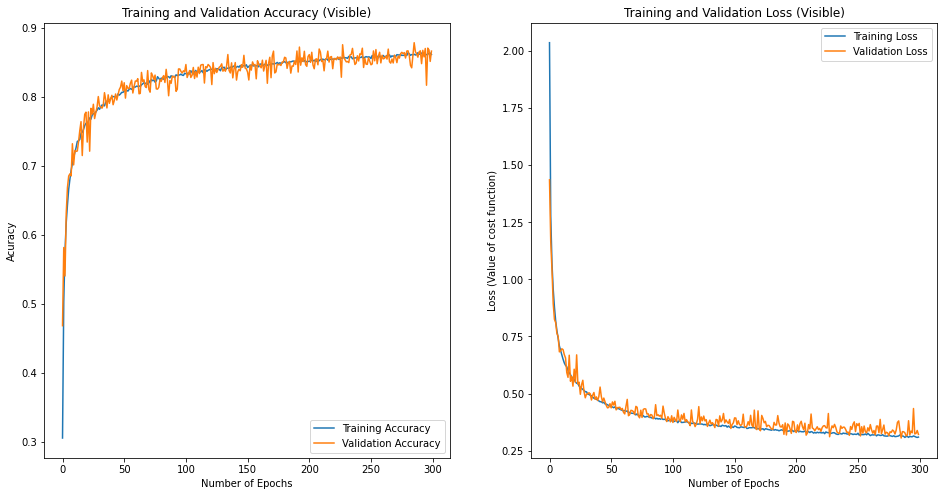

In [22]:
# Visualizing results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Visible)')
plt.ylabel('Acuracy')
plt.xlabel('Number of Epochs')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Visible)')
plt.ylabel('Loss (Value of cost function)')
plt.xlabel('Number of Epochs')
plt.show()

In [27]:
# # Save model as h5 (keras model) - 0.866 Accuracy
# model.save('/content/drive/MyDrive/colab_data/DLOrganicClassifierData/SavedModels/Aug_Vis__5000books_organic_model.h5')

In [28]:
# # Save the entire model as a SavedModel in drive - 0.866 Accuracy
# model.save('/content/drive/MyDrive/colab_data/DLOrganicClassifierData/SavedModels/Aug_Vis__5000books_organic_model') 

# Model Evaluation

In [25]:
# Model Accuracy
scores = model.evaluate(x_test, y_test, verbose=0)
print('The test Accuracy is: ', scores[1])
print('The test Loss is: ', scores[0])

The test Accuracy is:  0.866049587726593
The test Loss is:  0.30348658561706543


In [26]:
# Classification report
y_pred = model.predict(x_test) # Whole test set

predicted_categories = np.argmax(y_pred, axis=1) 
true_categories_argmax = np.argmax(y_test, axis=1)

print(classification_report(true_categories_argmax, predicted_categories))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       433
           1       0.94      0.96      0.95       482
           3       0.98      0.94      0.96       447
           5       0.96      0.93      0.94       481
           6       0.85      0.84      0.85       682
           7       0.93      0.96      0.95       489
           8       0.84      0.98      0.90       502
           9       0.93      0.88      0.90       536
          10       0.99      1.00      0.99       467
          11       0.89      0.95      0.92       513
          13       0.94      0.99      0.97       463
          14       0.95      0.96      0.96       520
          15       0.94      0.98      0.96       466
          17       0.00      0.00      0.00       469
          18       0.86      0.95      0.90       467
          19       0.00      0.00      0.00       507
          20       0.91      0.95      0.93       547
          21       0.87    